In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import seaborn as sns
sns.set_theme(style="ticks", font_scale=2)
import os
import json
from datetime import datetime
import inspect
import os
import sys
import importlib
import matplotlib.gridspec as gridspec

sys.path.append('../Classes')
import sgh_class

import colorsys
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [3]:
red = ['#fda2b7', '#d10333', '#6c011a']
yellow = ['#fde69a', '#f9c105', '#c79b04']
blue = ['#3fb5fb', '#0384d0', '#02456c']
p = np.linspace(0.01/180, 600/180, 500)

In [5]:
run_code = False

if run_code:
    x = sgh_class.SGH_class()
    x.params.update(tree_root_active=0, shading_active=1)
    sol0 = []; sol1 = [];
    for precip in p:
        sol0.append(x.solutions_fsolve(p=precip, c=0))
        sol1.append(x.solutions_fsolve(p=precip, c=0.5))
    combined_array = np.hstack([p.reshape(-1, 1), np.array(sol0), np.array(sol1)])
    combined_array[:,[1,3]] *= 1000  # convert biomass from kg to g
    np.savetxt('cartoon.csv', combined_array)

data = np.loadtxt('cartoon.csv')

(p, B0, S0, B1, S1) = data.T

# sol0 = x.
# B_zero = s1.B_of_P(p, 0)
B_zero = B0
B_tc_1 = B1

In [6]:
abs_diff = np.abs(B_zero - B_tc_1)[10:]
index = np.argmin(abs_diff) + 10  # +10 because we skipped the first 10 elements
intersection_p = p[index]
intersection_B = B_zero[index]

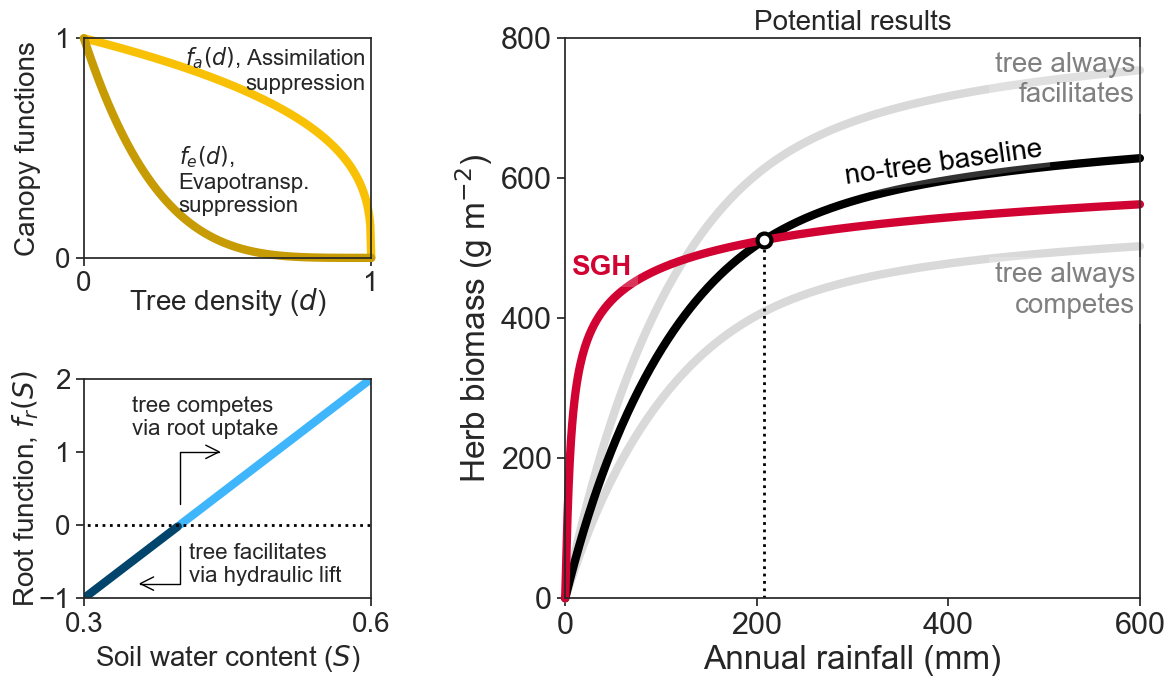

In [7]:
fig = plt.figure(figsize=(12, 7))
# fig, ax = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [0.5, 1], 'height_ratios': [1, 1]})
# fig.subplots_adjust(top=0.95, bottom=0.08, wspace=0.3, hspace=0.4, left=0.08, right=0.98)

gs = fig.add_gridspec(2,2, width_ratios=[0.5, 1], height_ratios=[1, 1])
fig.subplots_adjust(top=0.95, bottom=0.15, wspace=0.45, hspace=0.55, left=0.08, right=0.96)
ax_cano = fig.add_subplot(gs[0, 0])
ax_root = fig.add_subplot(gs[1, 0])
ax_tran = fig.add_subplot(gs[:, 1])

##################################
# Panels on the TOP of the figure
##################################

cover = np.linspace(0, 1, 300)
ess = cover.copy()
L1 = -1.0
L2 = 2.0
sh = 0.3
sfc = 0.6
m = (L2 - L1) / (sfc - sh)
def fa(c):
    return (1 - c) ** (1/3.0)
def fe(c):
    return (1 - c) ** (4.0)
def relu(x):
    return np.maximum(0, x)
def fr(s):
    return L1 + m*relu(s - sh) - m*relu(s - sfc)

ax_cano.plot(cover, fa(cover), color=yellow[1], lw=6, clip_on=False)
ax_cano.plot(cover, fe(cover), color=yellow[2], lw=6, clip_on=False)
ax_cano.text(
        0.98, 0.97, r'$f_a(d)$,' +' Assimilation\nsuppression',
        fontsize=16, va='top', ha='right',)
ax_cano.text(
        0.33, 0.52, r'$f_e(d)$,' + '\nEvapotransp.\nsuppression',
        fontsize=16, va='top', ha='left',)
ax_cano.set(xlim=(0, 1),
          ylim=(0, 1),
          xticks=[0,1],
          yticks=[0,1],)
ax_cano.set_xlabel(r'Tree density ($d$)', fontsize=20, labelpad=-8)
ax_cano.set_ylabel('Canopy functions', fontsize=20)
ax_cano.tick_params(axis='both', which='major', labelsize=20)

is_lift_mask = np.where(fr(ess)>0, True, False)
ax_root.plot(ess[is_lift_mask], fr(ess[is_lift_mask]), color=blue[0], lw=6, clip_on=True)
ax_root.plot(ess[~is_lift_mask], fr(ess[~is_lift_mask]), color=blue[2], lw=6, clip_on=True)
# ax_root.plot(ess, 0.5*fr(ess), color=blue[0], lw=6, clip_on=True)
ax_root.plot(ess, 0.0*fr(ess), color='black', lw=2, ls=':', clip_on=True)

ax_root.set(xlim=(0.3, 0.6),
          ylim=(-1, 2),
          xticks=[0.3,0.6],
          yticks=[-1,0,1,2])
# ax_root.yaxis.set_label_position("right")
# ax_root.yaxis.tick_right()
ax_root.set_xlabel(r'Soil water content ($S$)', fontsize=20)
# ax_cano.xaxis.set_label_coords(-0.2, 0.50)
ax_root.set_ylabel(r'Root function, $f_r(S)$', fontsize=20)
ax_root.yaxis.set_label_coords(-0.15, 0.50)
ax_cano.yaxis.set_label_coords(-0.15, 0.50)
ax_root.tick_params(axis='both', which='major', labelsize=20)

# ax_cano.set_title("Canopy mechanism", color=yellow[2], fontsize=20)
# ax_root.set_title("Root mechanism", color=blue[2], fontsize=20)

# ax_root.text(0.59, 1.9, r'$d=1$',
#          fontsize=16, verticalalignment='top',
#          horizontalalignment='right',
#          rotation=0,
#          bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
#          )
# ax_root.text(
#         0.59, 0.8, r'$d=0.5$',
#         fontsize=16, va='center', ha='right',
#         bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
# )
# ax_cano.text(0.02, 0.02, 'a', transform=ax_cano.transAxes, fontsize=26, weight='bold', ha='left', va='bottom')
# ax_root.text(0.02, 0.98, 'b', transform=ax_root.transAxes, fontsize=26, weight='bold', va='top')
# ax_tran.text(0.02, 0.98, 'c', transform=ax_tran.transAxes, fontsize=26, weight='bold', va='top')

xpos = 0.59
# ax_root.annotate('', xy=(xpos, -0.05), xytext=(xpos, -0.50),
#                  arrowprops=dict(color='black',arrowstyle="<-"))
# ax_root.annotate('', xytext=(xpos, 0.05), xy=(xpos, 0.50),
#                  arrowprops=dict(color='black',arrowstyle="->"))
# ax_root.text(xpos-0.005, 0.4, 'Usage', va='top', ha='right', fontsize=16)
# ax_root.text(xpos-0.005, -0.4, 'Provision', va='bottom', ha='right', fontsize=16)

ax_root.annotate("",
                xy=(0.45, 1.0), xycoords='data',
                xytext=(0.4, 0.0), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=15, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle,angleA=-90,angleB=180,rad=0",
                                ),
                )
ax_root.text(0.35, 1.17, 'tree competes\nvia root uptake', va='bottom', ha='left', fontsize=16)
ax_root.annotate("",
                xy=(0.35, -0.8), xycoords='data',
                xytext=(0.4, 0.0), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=15, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle,angleA=-90,angleB=180,rad=0",
                                ),
                )
ax_root.text(0.41, -0.83, 'tree facilitates\nvia hydraulic lift', va='bottom', ha='left', fontsize=16)

##################################
# Panels on the BOTTOM of the figure
##################################

# Synthetic model for left and middle plots
rain = np.linspace(0, 600, 300)
scaling_factor = 600 / 80  # = 7.5

# Shared gray line across both plots
gray_line = scaling_factor * 70 * (1 - np.exp(-0.05 * rain))

# Blue line *below* gray in competition plot (axs[0])
blue_comp = scaling_factor * 55 * (1 - np.exp(-0.05 * rain))

# Blue line *above* gray in facilitation plot (axs[1])
blue_facil = scaling_factor * 85 * (1 - np.exp(-0.05 * rain))

x_vals = p * 180

# Generate synthetic blue curves relative to real gray
blue_comp = 0.8 * B_zero     # always below
blue_facil = 1.2 * B_zero    # always above

# Panel a: Competition (blue < gray)
# Panel a: Competition (blue < gray)
ax_tran.plot(x_vals, blue_comp, color=[0.85]*3, lw=6, clip_on=False)
ax_tran.plot(x_vals, blue_facil, color=[0.85]*3, lw=6, clip_on=False)
ax_tran.plot(x_vals, B_zero, color='black', lw=6, linestyle='-', clip_on=False)  # dotted gray
ax_tran.plot(x_vals, B_tc_1, color=red[1], lw=6, clip_on=False)
ax_tran.plot([intersection_p*180], [intersection_B], 'o', mfc='white', mec="black", mew=3, markersize=10, clip_on=False)

ax_tran.text(
    595, 780, 
    'tree always\nfacilitates', 
    color=[0.5]*3, fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    595, 480, 
    'tree always\ncompetes', 
    color=[0.5]*3, fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    500, 660, 
    'no-tree baseline',
    rotation=8,
    color='black', fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    70, 490, 
    'SGH', weight='bold',
    color=red[1], fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.plot([intersection_p*180, intersection_p*180], [0, intersection_B*0.98], color='black', lw=2, ls=':')

# ax_tran.annotate('transition point', 
#                 xy=(210, 500), 
#                 xytext=(200, 260),
#                 size=20,
#                 ha='left',
#                 va='top',
#                 arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3", linewidth=3))

# ax_tran.text(100, 450, u"\u2460", fontsize=40, color='black', weight='bold', ha='center', va='center')

ax_tran.set(xlim=(0, 600),
          ylim=(0, 800),
          xticks=[0, 200, 400, 600],
          yticks=[0, 200, 400, 600, 800])
ax_tran.set_title("Potential results", fontsize=20)
ax_tran.set_xlabel(r'Annual rainfall (mm)')#, labelpad=0)
# ax_tran.text(300, 10, r'Annual rainfall (mm)', fontsize=20, ha='center', va='bottom')
ax_tran.set_ylabel(r'Herb biomass (g m${}^{-2}$)')

# fig.savefig('schematics2.png', dpi=300)
fig.savefig('schematics3.pdf')
